   id  price  cluster
0   1     10        2
1   2     20        2
2   3     30        2
3   4    200        1
4   5    220        1
5   6    250        1
6   7   1000        0
7   8   1100        0
8   9   1200        0


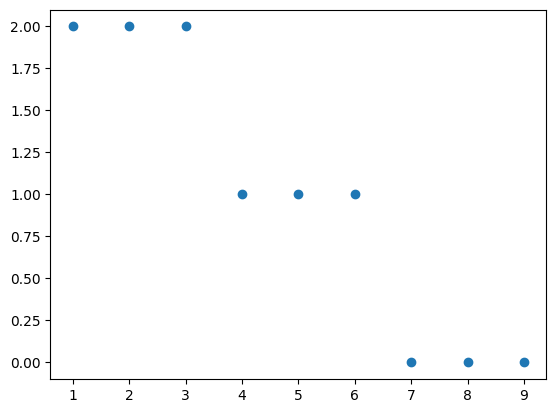

In [74]:
import sqlglot
import pandas as pd
import numpy as np
from sqlglot import Dialect
import sqlglot.dialects
from sqlglot.expressions import Func
from sqlglot.generator import Generator
from sqlglot.parser import Parser
from sklearn.cluster import KMeans
from sqlglot.tokens import Tokenizer
from ml import MachineLearning
from visualizations import Visualization

class ClusterKMeans(Func):
    arg_count = 1 


    @property
    def sql_name(self):
        # Force the function name to be "CLUSTER"
        return "CLUSTER"
    
    def execute(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError(f"A coluna '{column_name}' não foi encontrada no DataFrame.")

        data = df[column_name].values.reshape(-1, 1)
        mlclass = MachineLearning()

        kmeans = mlclass.cluster_kmeans(data, n_clusters=3)
        df["cluster"] = kmeans
        return df

    def to_cte(self, df, alias="resultados_cluster"):
        return self.execute(df, self.this.name)

class Scatter(Func):
    arg_count = 1

    def execute(self, x, y):
        vis = Visualization()
        vis.scatter(x,y)
        return True


    def to_cte(self, x,y):
        return self.execute(x,y)


class CustomDialect(Dialect):
    class Tokenizer(Tokenizer):
        KEYWORDS = {
            **Tokenizer.KEYWORDS,
            
        }

    class Parser(Parser):
        FUNCTIONS = {**Parser.FUNCTIONS, "CLUSTER": ClusterKMeans.from_arg_list, "SCATTER": Scatter.from_arg_list}


    class Generator(Generator):
        TRANSFORMS = {
            **Generator.TRANSFORMS,
            ClusterKMeans: lambda self, expr: f"CLUSTER({self.sql(expr.this)})",
            Scatter: lambda self, expr: f"SCATTER({self.sql(expr.this)})",
        }

df = pd.DataFrame({
    "id": range(1, 10),
    "price": [10, 20, 30, 200, 220, 250, 1000, 1100, 1200],
})

query = """
WITH resultados_cluster AS (SELECT CLUSTER(price) FROM df)  
SELECT SCATTER(price) FROM resultados_cluster;
"""

expression = sqlglot.parse_one(query, dialect=CustomDialect)


cluster_expr = expression.find(ClusterKMeans)

df_clusterizado = cluster_expr.to_cte(df)

scatter_expr = expression.find(Scatter)

scatter = scatter_expr.to_cte(df_clusterizado['id'],df_clusterizado['cluster'])

print(df_clusterizado)


In [75]:
expression

Select(
  expressions=[
    Scatter(
      this=Column(
        this=Identifier(this=price, quoted=False)))],
  from=From(
    this=Table(
      this=Identifier(this=resultados_cluster, quoted=False))),
  with=With(
    expressions=[
      CTE(
        this=Select(
          expressions=[
            ClusterKMeans(
              this=Column(
                this=Identifier(this=price, quoted=False)))],
          from=From(
            this=Table(
              this=Identifier(this=df, quoted=False)))),
        alias=TableAlias(
          this=Identifier(this=resultados_cluster, quoted=False)))]))

In [ ]:
from sqlglot import parse_one
from sqlglot.executor.python import PythonExecutor

class CustomExecutor(PythonExecutor):
    def _eval_function(self, node: Func, scope: dict):
        # Check if the node is one of your custom functions.
        if isinstance(node, ClusterKMeans):
            # Assume the argument is an Identifier; extract its name.
            column_name = node.this.name
            # Get the table (here "df") from the execution scope.
            df = scope.get("df")
            # Call your custom function's execute method.
            return node.execute(df, column_name)
        elif isinstance(node, Scatter):
            # For Scatter, evaluate the argument.
            # (If you have multiple arguments, adjust accordingly.)
            x_value = self._eval(node.this, scope)
            # In your definition, Scatter.execute expects two arguments (x and y).
            # You may need to modify your function or extract a second argument if your SQL provides one.
            # For now, we'll pass None as a placeholder for y.
            return node.execute(x_value, None)
        # For all other functions, use the default behavior.
        return super()._eval_function(node, scope)



df = [
    {"id":1, 'price':100},
    {"id":2, 'price':200},
    {"id":3, 'price':150},
    {"id":4, 'price':90},
    {"id":5, 'price':1200},
    {"id":6, 'price':1500},
    {"id":7, 'price':3300},
    {"id":8, 'price':152},
    {"id":9, 'price':2000},
    {"id":10, 'price':0},
    ]

# query = """
# WITH resultados_cluster AS (SELECT CLUSTER(price) FROM df)  
# SELECT SCATTER(price) FROM resultados_cluster;from sqlglot import parse_one
from sqlglot.executor.python import PythonExecutor

class CustomExecutor(PythonExecutor):
    def _eval_function(self, node: Func, scope: dict):
        # Check if the node is one of your custom functions.
        if isinstance(node, ClusterKMeans):
            # Assume the argument is an Identifier; extract its name.
            column_name = node.this.name
            # Get the table (here "df") from the execution scope.
            df = scope.get("df")
            # Call your custom function's execute method.
            return node.execute(df, column_name)
        elif isinstance(node, Scatter):
            # For Scatter, evaluate the argument.
            # (If you have multiple arguments, adjust accordingly.)
            x_value = self._eval(node.this, scope)
            # In your definition, Scatter.execute expects two arguments (x and y).
            # You may need to modify your function or extract a second argument if your SQL provides one.
            # For now, we'll pass None as a placeholder for y.
            return node.execute(x_value, None)
        # For all other functions, use the default behavior.
        return super()._eval_function(node, scope)



df = [
    {"id":1, 'price':100},
    {"id":2, 'price':200},
    {"id":3, 'price':150},
    {"id":4, 'price':90},
    {"id":5, 'price':1200},
    {"id":6, 'price':1500},
    {"id":7, 'price':3300},
    {"id":8, 'price':152},
    {"id":9, 'price':2000},
    {"id":10, 'price':0},
    ]

# query = """
# WITH resultados_cluster AS (SELECT CLUSTER(price) FROM df)  
# SELECT SCATTER(price) FROM resultados_cluster;
# """

query = """ 
SELECT CLUSTER(price) from df
"""
from sqlglot.planner import Plan
from sqlglot.executor.table import Table, ensure_tables
ast = Plan(parse_one(query, dialect=CustomDialect))

tables = ensure_tables({"df":df}, dialect=CustomDialect)

CustomExecutor(tables=tables).execute(ast)


# """

query = """ 
SELECT CLUSTER(price) from df
"""
from sqlglot.planner import Plan
from sqlglot.executor.table import Table, ensure_tables
ast = Plan(parse_one(query, dialect=CustomDialect))

tables = ensure_tables({"df":df}, dialect=CustomDialect)

CustomExecutor(tables=tables).execute(ast)



ExecuteError: Step 'Scan: df (125496225307952)' failed: 'str' object is not callable

# A ideia aqui é realmente ser algo que já pegue todos os dados e salve eles e depois só saia aplicando as funções propriamente ditas.. mas como fazer isso quando tiver resultados em cima do resultado da query?

por exemplo, como lidar com as CTEs?

## Trying to integrate everything

In [2]:
import psycopg2
import sqlglot
import pandas as pd
import numpy as np
from sqlglot import Dialect
import sqlglot.dialects
from sqlglot.expressions import Func
from sqlglot.generator import Generator
from sqlglot.parser import Parser
from sklearn.cluster import KMeans
from sqlglot.tokens import Tokenizer
from ml import MachineLearning
from visualizations import Visualization

class Cluster(Func):
    arg_count = 1 

    def execute(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError(f"A coluna '{column_name}' não foi encontrada no DataFrame.")

        data = df[column_name].values.reshape(-1, 1)
        mlclass = MachineLearning()

        kmeans = mlclass.cluster_kmeans(data, n_clusters=3)
        df["cluster"] = kmeans
        return df

    def to_cte(self, df, alias="resultados_cluster"):
        return self.execute(df, self.this.name)

class Scatter(Func):
    arg_count = 1

    def execute(self, x, y):
        vis = Visualization()
        vis.scatter(x,y)
        return True


    def to_cte(self, x,y):
        return self.execute(x,y)


class CustomDialect(Dialect):
    class Tokenizer(Tokenizer):
        KEYWORDS = {
            **Tokenizer.KEYWORDS,
            
        }

    class Parser(Parser):
        FUNCTIONS = {**Parser.FUNCTIONS, "CLUSTER": Cluster.from_arg_list, "SCATTER": Scatter.from_arg_list}


    class Generator(Generator):
        TRANSFORMS = {
            **Generator.TRANSFORMS,
            Cluster: lambda self, expr: f"CLUSTER({self.sql(expr.this)})",
            Scatter: lambda self, expr: f"SCATTER({self.sql(expr.this)})",
        }

df = pd.DataFrame({
    "id": range(1, 10),
    "price": [10, 20, 30, 200, 220, 250, 1000, 1100, 1200],
})

query = """
WITH resultados_cluster AS (SELECT CLUSTER(price),age FROM df), teste2 AS (SELECT CLUSTER(age) FROM df)
SELECT SCATTER(price) FROM resultados_cluster;
"""

# Eu preciso sempre transformar de SQL/Postgres para DataFrame.

# Pegar do banco apenas a tabela e os dados que tiver dentro de CLUSTER(). Então eu vou fazer uma função que vai puxar o do banco algo como SELECT price FROM df onde DF é a a table_name do postgres.
# Após isso, eu vou transformar isso em um DataFrame e passar pro codigo em si. Para toda tabela isso tem que ser feito

# Talvez tentar pegar todas as aparições de Table() na AST e já salvar isso nos DataFrames. Ao mesmo tempo, manter algo assim no CTEs

from sqlglot.expressions import Table

ast = sqlglot.parse_one(query, dialect=CustomDialect)

from sqlglot.optimizer.scope import build_scope

root = build_scope(ast)

from collections import defaultdict

dbDict = defaultdict(list)

for index,scope in enumerate(root.traverse()):
    tableName = str(scope.tables[0])
    columnUsed = str(scope.columns[0]) 
    dbDict[tableName].append(columnUsed)
    

dbDict['content'].append('title')
DATAFRAMES = dict()

def execute_query(query):
    """Executes a SQL query in PostgreSQL and returns a Pandas DataFrame"""
    conn = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="password",
        host="localhost",
        port="5432"
    )
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(rows, columns=columns)


def fromDbToDf(schema):
    string = f"SELECT {", ".join(dbDict[schema])} FROM {schema};"
    # Run query to any source (wrapper to any db)
    df = execute_query(string)
    # transform into dataframe and append into dataframes
    DATAFRAMES[schema] = df

    return True

    # Com isso, eu tenho todos os dados necessários de tabelas originais. a partir de agora eu preciso só executar as funções e construir novas CTEs. 
    # TODO: testar a questão de joins.. (ou partir do principio que as coisas ja estão feitas um join???)
fromDbToDf('content')
DATAFRAMES['content']
# cluster_expr = expression.find(Cluster)

# df_clusterizado = cluster_expr.to_cte(df)

# scatter_expr = expression.find(Scatter)

# scatter = scatter_expr.to_cte(df_clusterizado['id'],df_clusterizado['cluster'])

# print(df_clusterizado)


# A ideia daqui é a seguinte: Percorrer a árvore e ir executando de acordo com a árvore.. Eu ja terei os dados originais, só preciso aplicar as funções e criar as CTEs..

,title
0,‘Beautiful And Sad At The Same Time’: Ukrainia...
1,Biden Says Queen's Death Left 'Giant Hole' For...
2,Bill To Help Afghans Who Escaped Taliban Faces...
3,Mark Meadows Complies With Justice Dept. Subpo...
4,Democrats Nominate Seth Magaziner In Key Rhode...
...,...
31971,Jon Stewart Made Elizabeth Warren Puke
31972,Why Chris Christie Should NOT Be President
31973,GOP's Old Ploy: Tag President Obama as the Rac...
31974,Lawmakers Introduce Bill To Tackle Misleadingl...


## Codigo para percorrer a árvore e ir executando

In [49]:
import psycopg2
import sqlglot
import pandas as pd
import numpy as np
from sqlglot import Dialect
import sqlglot.dialects
from sqlglot.expressions import Func
from sqlglot.generator import Generator
from sqlglot.parser import Parser
from sklearn.cluster import KMeans
from sqlglot.tokens import Tokenizer
from ml import MachineLearning
from visualizations import Visualization

class ClusterKMeans(Func):
    arg_count = 1 

    def execute(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError(f"A coluna '{column_name}' não foi encontrada no DataFrame.")

        data = df[column_name].values.reshape(-1, 1)
        mlclass = MachineLearning()

        kmeans = mlclass.cluster_kmeans(data, n_clusters=3)
        df["cluster"] = kmeans
        return df

    def to_cte(self, df, alias="resultados_cluster"):
        return self.execute(df, self.this.name)

class Scatter(Func):
    arg_count = 1

    def execute(self, x, y):
        vis = Visualization()
        vis.scatter(x,y)
        return True


    def to_cte(self, x,y):
        return self.execute(x,y)


class CustomDialect(Dialect):
    class Tokenizer(Tokenizer):
        KEYWORDS = {
            **Tokenizer.KEYWORDS,
            
        }

    class Parser(Parser):
        FUNCTIONS = {**Parser.FUNCTIONS, "CLUSTER": ClusterKMeans.from_arg_list, "SCATTER": Scatter.from_arg_list}


    class Generator(Generator):
        TRANSFORMS = {
            **Generator.TRANSFORMS,
            Cluster: lambda self, expr: f"CLUSTER({self.sql(expr.this)})",
            Scatter: lambda self, expr: f"SCATTER({self.sql(expr.this)})",
        }

df = pd.DataFrame({
    "id": range(1, 10),
    "price": [10, 20, 30, 200, 220, 250, 1000, 1100, 1200],
})

query = """
WITH resultados_cluster AS (SELECT CLUSTER(price), age FROM df), teste2 AS (SELECT CLUSTER(age) FROM df)
SELECT SCATTER(price) FROM resultados_cluster;
"""

# A partir daqui é onde vai começar a percorrer

# Percorre, executa, salva em um CTE onde for necessário salvar nos CTEs


from sqlglot.expressions import Table
from sqlglot.optimizer.scope import build_scope
from collections import defaultdict

ast = sqlglot.parse_one(query, dialect=CustomDialect)
root = build_scope(ast)
dbDict = defaultdict(list)

# for index,scope in enumerate(root.traverse()):
#     tableName = str(scope.tables[0])
#     columnUsed = str(scope.columns[0]) 
#     dbDict[tableName].append(columnUsed)

root

Scope<WITH resultados_cluster AS (SELECT CLUSTER_K_MEANS(price), age FROM df), teste2 AS (SELECT CLUSTER_K_MEANS(age) FROM df) SELECT SCATTER(price) FROM resultados_cluster>

In [ ]:
tables_sql = list(expression.find_all(Table))
tables_sql[::-1]

In [ ]:
# Codigo gerado
def process_query_with_dialect(sql):
    parsed = parse_one(sql, dialect=CustomDialect)
    cte_results = {}

    # If the query contains CTEs (WITH clause), handle them first
    if isinstance(parsed, With):
        for cte in parsed.expressions:
            cte_name = cte.alias_or_name
            cte_sql = cte.this.to_sql(dialect=CustomDialect)

            # Execute the CTE query and store the results
            print(f"Executing CTE: {cte_name}\nSQL: {cte_sql}")
            df_cte = execute_query(cte_sql)

            # Apply the functions from the custom dialect to the CTE result
            for func_name, func_class in CUSTOM_FUNCTIONS.items():
                if func_name in cte_sql:
                    func = func_class()
                    df_cte = func.execute(df_cte, "price")  # Adjust column name dynamically

            cte_results[cte_name] = df_cte

    # Process the main query and apply functions
    main_query = parsed.this.to_sql(dialect=CustomDialect)
    print(f"Executing main query: {main_query}")
    df_main = execute_query(main_query)

    # Apply custom functions to the results of the main query
    for func_name, func_class in CUSTOM_FUNCTIONS.items():
        if func_name in sql:
            func = func_class()
            df_main = func.execute(df_main, "price")  # Adjust column name dynamically

    return df_main

# Example SQL query with CTE and custom functions
sql_query = """
WITH clustered_data AS (SELECT CLUSTER(price) FROM products)
SELECT SCATTER(price) FROM clustered_data;
"""

# Execute the query using the dynamic system with custom dialect and function handling
result_df = process_query_with_dialect(sql_query)

